This notebook is a part of the work 'Nucleation patterns of polymer crystals analyzed by machine learning models' and is written by Atmika Bhardwaj (bhardwaj@ipfdd.de).

The following machine learning models are employed in this notebook: AutoEncoders (AE), Hierarchical Clustering (HC), Gaussian Mixture Models (GMM), Multilayer Perceptron (MLP). We start by reading a coordinate file (dump file from LAMMPS) and analyze it to study the local environmental information of every coarse-grained bead. Then, we train an AE to compress that information and train a GMM on the compressed data to classify each coarse-grained into amorphous or crytalline depending on its enviromental fingerprint.

This notebook imports all the functions from another file called all_functions.py


In [1]:
import glob
import random
import pickle
import numpy                  as     np
from   numpy.random           import seed
import matplotlib.pyplot      as     plt
import matplotlib.cm          as     cm
import h5py                   as     h5py
from   mpl_toolkits.mplot3d   import Axes3D
from   natsort                import natsorted
from   sklearn                import preprocessing, mixture
from   sklearn.cluster        import AgglomerativeClustering
from   keras.models           import load_model
import sys
sys.path.insert(0, '../../../Jupyters/')
from   all_functions          import *
import matplotlib.ticker      as mticker
seed(1)
plt.rcParams["figure.figsize"]  = (6,5)
plt.rcParams["figure.dpi"]      = 300
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

2023-09-26 16:59:51.067073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-26 16:59:51.067093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
chainLength      = 1000
dx               = 0.4
Rmax             = 3.5
hid_dim          = 14
depth            = 14
nEpochs          = 650
VL               = 1
batchSize        = 50
validationSplit  = 0.2
L2               = 10e-7
LR               = 10e-5
g                = natsorted(glob.glob('../../../../01_raw_data/dump_files/dump.*'))


In [3]:
h5_file          = h5py.File('../../../all_parameters.h5', 'r')
h5_keys          = natsorted(list(h5_file.keys()))
file_num         = -1
obj              = ReadCoordinates(g[file_num], chainLength)
#rnd              = random.sample(range(0, obj.totalAtoms), 20000)
filename         = 'rnd_20k'
#pickle.dump(rnd, open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
rnd              = np.array(pickle.load(open(filename, 'rb')))
ae_training_data = np.array(h5_file.get(h5_keys[file_num]))[rnd]
ae_training_data = np.delete(ae_training_data, 10, axis = 1)
ae_training_data.shape

(20000, 17)

Epoch 1/650
320/320 [==============================] - 2s 2ms/step - loss: 0.3866 - val_loss: 0.1888 - lr: 1.0000e-04
Epoch 2/650
320/320 [==============================] - 1s 2ms/step - loss: 0.1254 - val_loss: 0.0949 - lr: 1.0000e-04
Epoch 3/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0879 - val_loss: 0.0840 - lr: 1.0000e-04
Epoch 4/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0809 - val_loss: 0.0786 - lr: 1.0000e-04
Epoch 5/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0741 - lr: 1.0000e-04
Epoch 6/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0722 - val_loss: 0.0704 - lr: 1.0000e-04
Epoch 7/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0690 - val_loss: 0.0676 - lr: 1.0000e-04
Epoch 8/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0666 - val_loss: 0.0655 - lr: 1.0000e-04
Epoch 9/650
320/320 [==============================] - 1

Epoch 70/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0348 - val_loss: 0.0339 - lr: 1.0000e-04
Epoch 71/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0345 - val_loss: 0.0338 - lr: 1.0000e-04
Epoch 72/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0333 - lr: 1.0000e-04
Epoch 73/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0342 - val_loss: 0.0332 - lr: 1.0000e-04
Epoch 74/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0341 - val_loss: 0.0331 - lr: 1.0000e-04
Epoch 75/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0339 - val_loss: 0.0331 - lr: 1.0000e-04
Epoch 76/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0337 - val_loss: 0.0330 - lr: 1.0000e-04
Epoch 77/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0336 - val_loss: 0.0327 - lr: 1.0000e-04
Epoch 78/650
320/320 [==========================

320/320 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0255 - lr: 1.0000e-04
Epoch 207/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0254 - lr: 1.0000e-04
Epoch 208/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0257 - lr: 1.0000e-04
Epoch 209/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0256 - lr: 1.0000e-04
Epoch 210/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0257 - lr: 1.0000e-04
Epoch 211/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0254 - lr: 1.0000e-04
Epoch 212/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0253 - lr: 1.0000e-04
Epoch 213/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0253 - lr: 1.0000e-04
Epoch 214/650
320/320 [==============================]

320/320 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 343/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0224 - lr: 1.0000e-04
Epoch 344/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0225 - lr: 1.0000e-04
Epoch 345/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0227 - lr: 1.0000e-04
Epoch 346/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0223 - lr: 1.0000e-04
Epoch 347/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0225 - lr: 1.0000e-04
Epoch 348/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 349/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0227 - lr: 1.0000e-04
Epoch 350/650
320/320 [==============================]

320/320 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0212 - lr: 5.0000e-05
Epoch 479/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0211 - lr: 5.0000e-05
Epoch 480/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0211 - lr: 5.0000e-05
Epoch 481/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0211 - lr: 5.0000e-05
Epoch 482/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0211 - lr: 5.0000e-05
Epoch 483/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0211 - lr: 5.0000e-05
Epoch 484/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0213 - lr: 5.0000e-05
Epoch 485/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0211 - lr: 5.0000e-05
Epoch 486/650
320/320 [==============================]

320/320 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 3.1250e-06
Epoch 615/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 3.1250e-06
Epoch 616/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 3.1250e-06
Epoch 617/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 3.1250e-06
Epoch 618/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 3.1250e-06
Epoch 619/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 3.1250e-06
Epoch 620/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 3.1250e-06
Epoch 621/650
320/320 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 3.1250e-06
Epoch 622/650
320/320 [==============================]

<IPython.core.display.Javascript object>


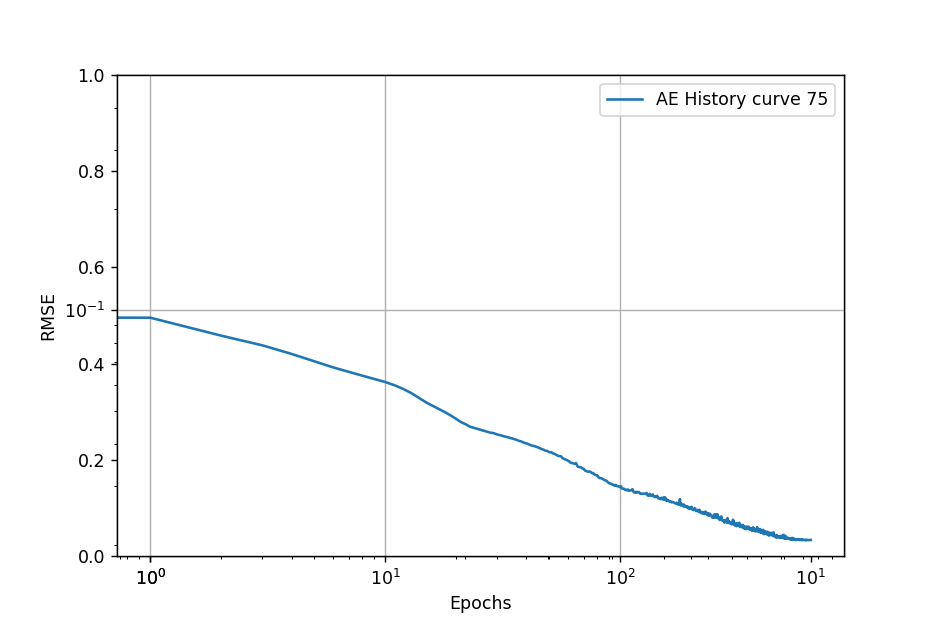

/tmp/ipykernel_2861204/3222805892.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,0.5)


In [20]:
autoencoder, encoder, hist, encoded = fixedSeeds(2, hid_dim, ae_training_data, depth, "elu", L2, VL, nEpochs, LR, validationSplit, batchSize, 'random_ae20k.sav')

histories = [hist]
names     = ["AE History curve 75","hist2"]
fig = plt.figure()
plt.xscale("log")
ax = plt.axes(xscale='log', yscale='log')
ax.grid();
c = 0
for h in histories:
    l    = h.history["loss"]
    lv   = h.history["val_loss"]
    t    = np.arange(len(l))
    name = names[c]
    plt.plot(t, lv , label=name)
    c   += 1
plt.ylim(0,0.5)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()


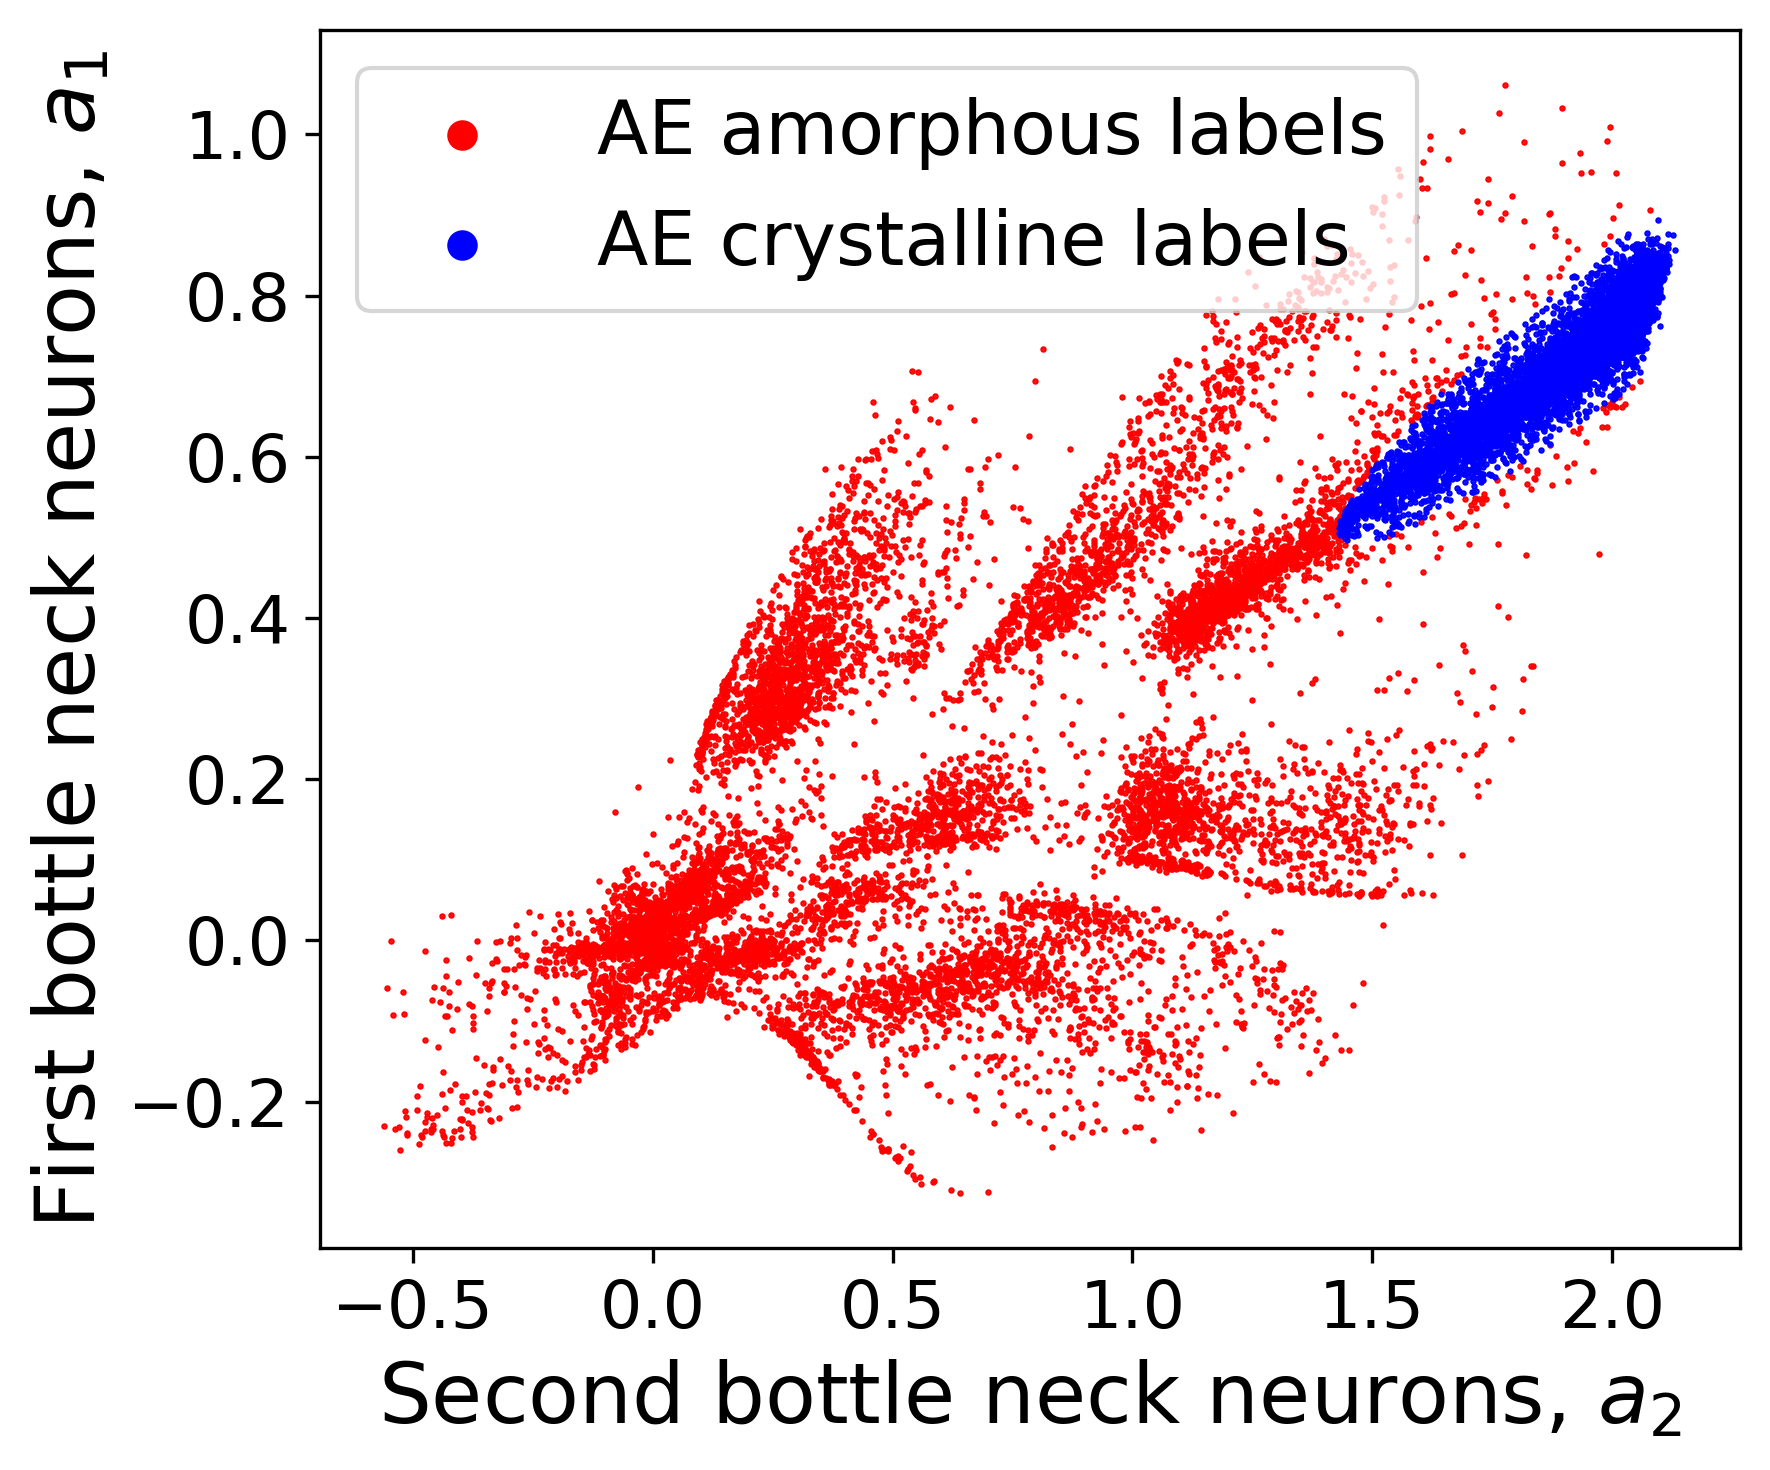

In [9]:
autoenc  = load_model("random_ae20k.sav")
encoded  = autoenc.predict(ae_training_data)

gmm = mixture.GaussianMixture(n_components = 2, covariance_type = "full")
yhc = gmm.fit_predict(encoded)

fig = plt.figure()
p1 = encoded[yhc==0]
plt.scatter(p1[:,1], p1[:,0], c = 'red',  s = 0.3, label = 'AE amorphous labels')
p1 = encoded[yhc==1]
plt.scatter(p1[:,1], p1[:,0], c = 'blue', s = 0.3, label = 'AE crystalline labels')

plt.xlabel('Second bottle neck neurons, $a_2$', fontsize = 20)
plt.ylabel('First bottle neck neurons, $a_1$',  fontsize = 20)
lgnd     = plt.legend(fontsize=18)
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])
    
plt.tight_layout()
plt.show()


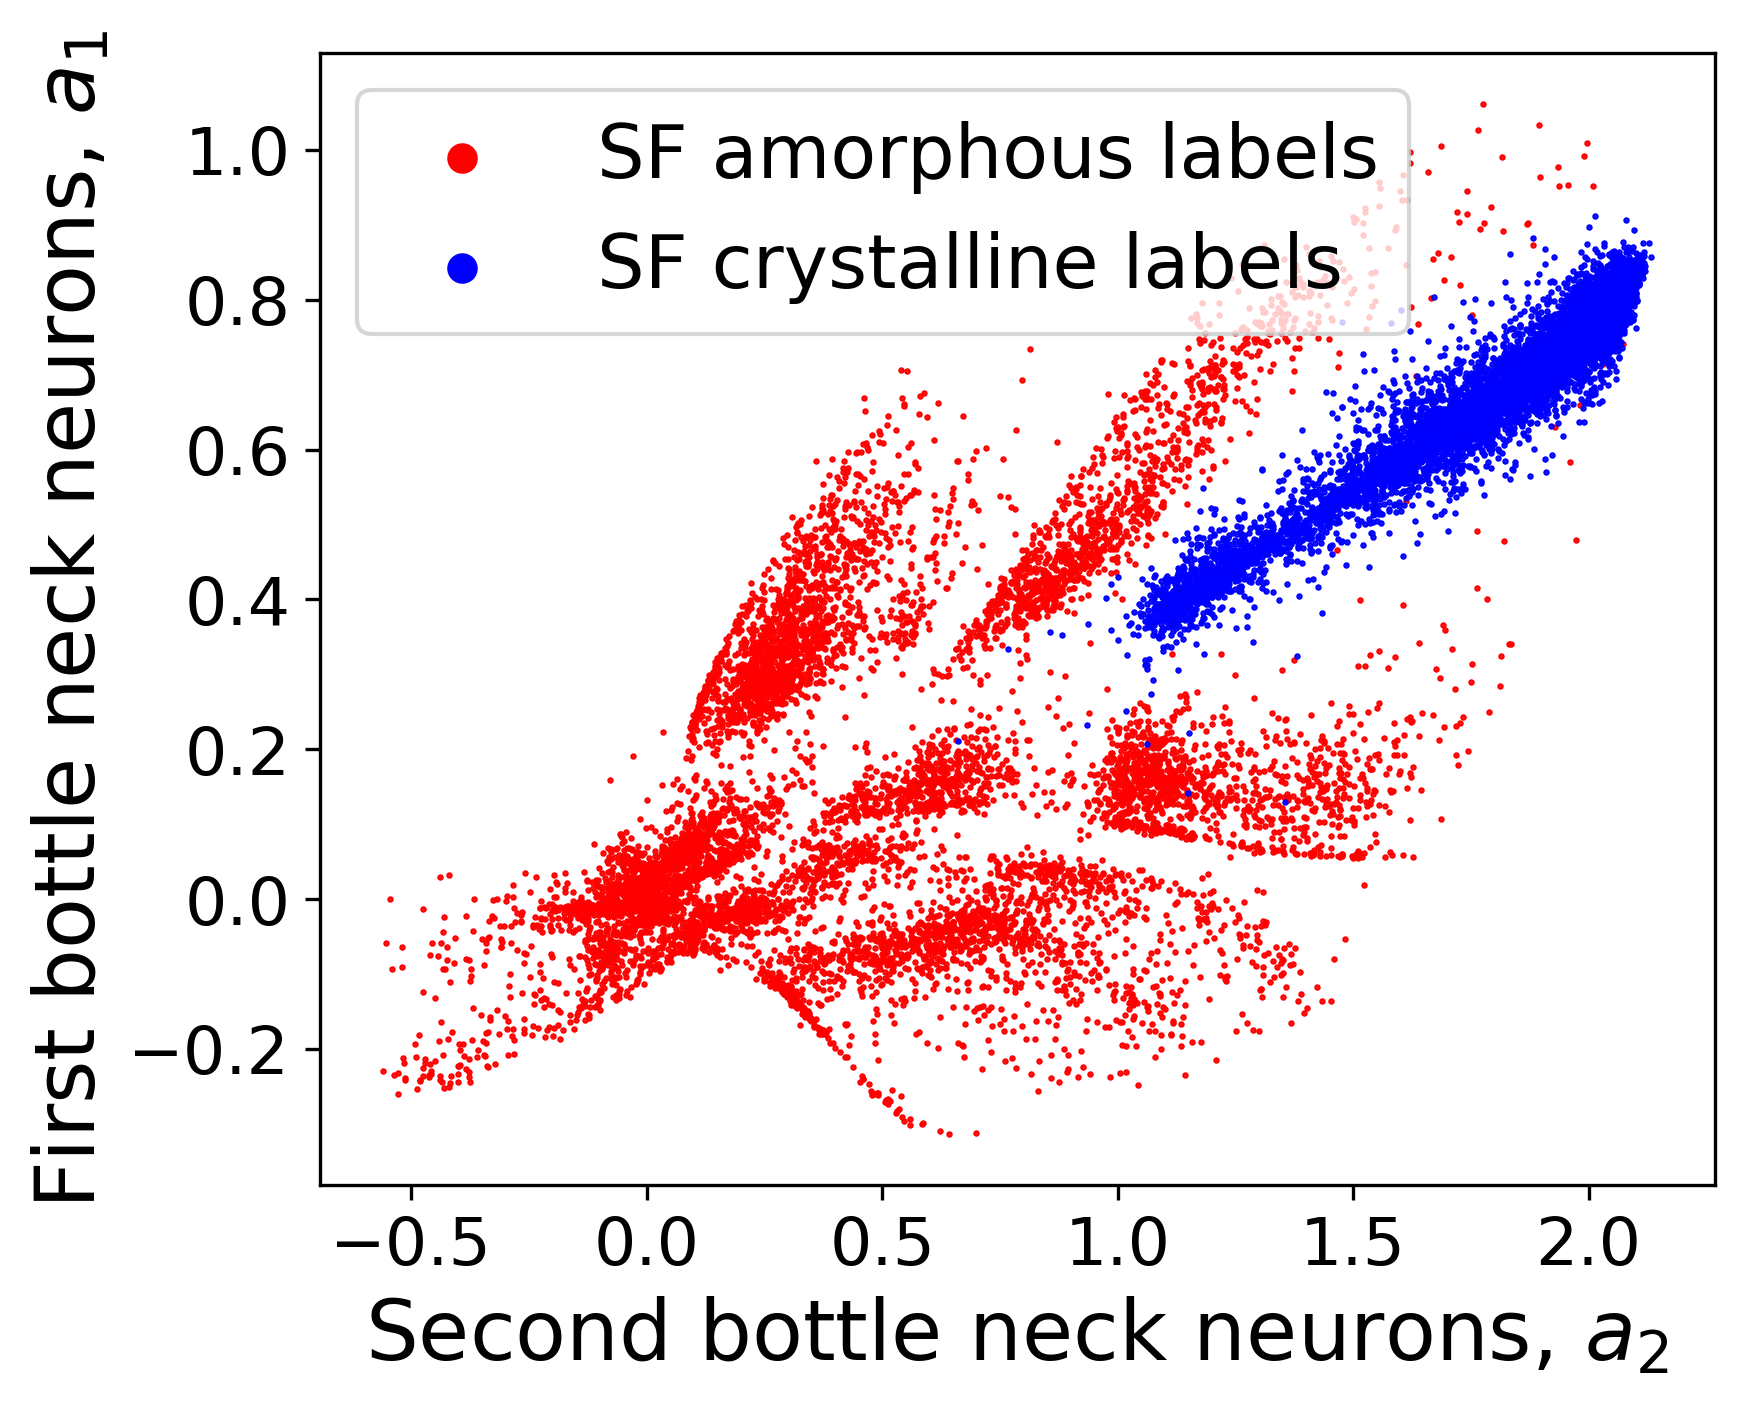

In [10]:
hc  = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
sf = hc.fit_predict(ae_training_data)

fig = plt.figure()
p1 = encoded[sf==0]
plt.scatter(p1[:,1], p1[:,0], c = 'red',  s = 0.3, label = 'SF amorphous labels')
p1 = encoded[sf==1]
plt.scatter(p1[:,1], p1[:,0], c = 'blue', s = 0.3, label = 'SF crystalline labels')

plt.xlabel('Second bottle neck neurons, $a_2$', fontsize = 20)
plt.ylabel('First bottle neck neurons, $a_1$',  fontsize = 20)
lgnd     = plt.legend(fontsize=18)
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

In [11]:
yhcae = np.where(yhc==1)[0]
yhcff = np.where(sf ==1)[0]

sum(np.in1d(yhcae, yhcff))/len(yhcae)*100

99.96564754379939

## Predictions on the whole time series using the trained model

In [8]:
all_labels_ae  = []
all_encoded    = []
autoenc        = load_model('random_ae20k.sav')

for i in np.arange(len(g)):
    
    training_data  = np.array(h5_file.get(h5_keys[i]))
    training_data  = np.delete(training_data, 10, axis = 1)
    encoded_output = autoenc.predict(training_data)
    all_encoded.append(encoded_output)
    
    label_ae   = gmm.predict(encoded_output)
    all_labels_ae.append(label_ae)
    print(i)
    
filename = 'AE_encoded.sav'
pickle.dump(all_encoded,     open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
filename = 'AE_labels.sav'
pickle.dump(all_labels_ae,   open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
